###Please finish the sections of the notebook labeled 'To Do.'

In [1]:
!pip install voxelmorph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19534 sha256=a432c339d5e89e1319a9f5b792aaa42aa640f51b7dc3605b16e99a42c8669cf0
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [2]:
import os, sys
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import voxelmorph as vxm
import neurite as ne
import random
from matplotlib import pyplot as plt

In [5]:
!unzip /content/train_vols.npy.zip
!unzip /content/validate_vols.npy.zip

Archive:  /content/train_vols.npy.zip
  inflating: train_vols.npy          
Archive:  /content/validate_vols.npy.zip
  inflating: validate_vols.npy       


In [6]:
x_train = np.load('/content/train_vols.npy')
x_val = np.load('/content/validate_vols.npy')
# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


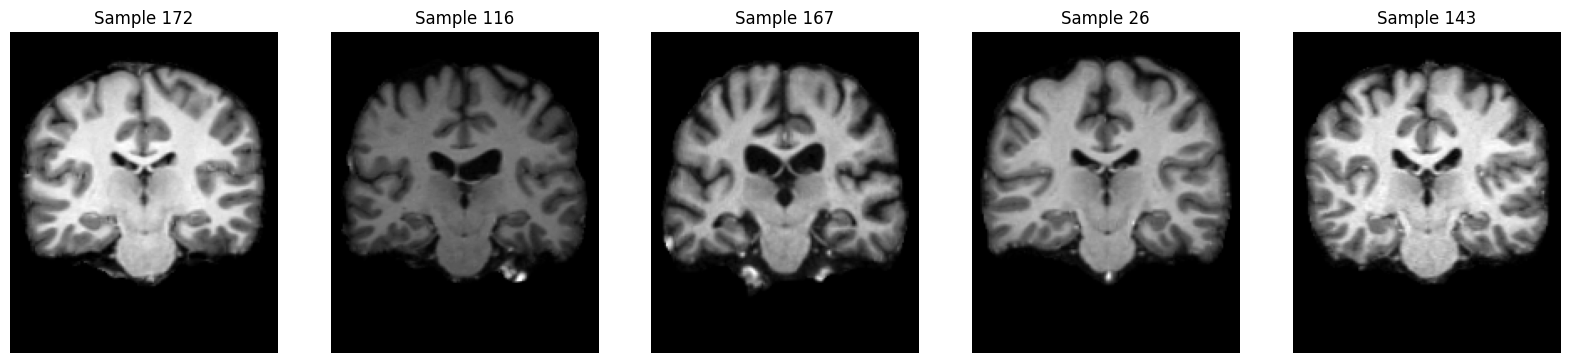

In [7]:
### To Do: plot 5 random sample from train data
random_indices = random.sample(range(x_train.shape[0]), 5)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {idx}')

plt.show()

# nb_vis = 5
# idx = np.random.randint(0, x_train.shape[0], [5,])
# example_digits = [f for f in x_train[idx, ...]]
# # visualize
# ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [8]:
# unet
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]


In [9]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

In [10]:
# initializing train data generator
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)


In [11]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

In [12]:
hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);

Epoch 1/5


<ipython-input-12-2a3595386513>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);


5/5 - 15s - loss: 0.0064 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 3.5485e-08 - 15s/epoch - 3s/step
Epoch 2/5
5/5 - 0s - loss: 0.0063 - vxm_dense_transformer_loss: 0.0063 - vxm_dense_flow_loss: 3.9241e-07 - 303ms/epoch - 61ms/step
Epoch 3/5
5/5 - 0s - loss: 0.0078 - vxm_dense_transformer_loss: 0.0078 - vxm_dense_flow_loss: 1.8879e-06 - 305ms/epoch - 61ms/step
Epoch 4/5
5/5 - 0s - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 6.9233e-06 - 304ms/epoch - 61ms/step
Epoch 5/5
5/5 - 0s - loss: 0.0077 - vxm_dense_transformer_loss: 0.0077 - vxm_dense_flow_loss: 2.4350e-05 - 283ms/epoch - 57ms/step


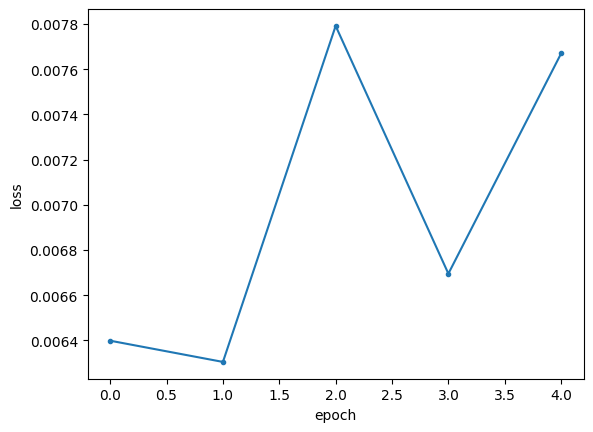

In [13]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

In [14]:
# TO DO: train model for 100 more epoches
hist_100 = vxm_model.fit_generator(train_generator, epochs=105, steps_per_epoch=5, verbose=2);

Epoch 1/105


<ipython-input-14-7db44f4e5b54>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist_100 = vxm_model.fit_generator(train_generator, epochs=105, steps_per_epoch=5, verbose=2);


5/5 - 0s - loss: 0.0072 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 6.2436e-05 - 350ms/epoch - 70ms/step
Epoch 2/105
5/5 - 0s - loss: 0.0068 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 7.3682e-05 - 311ms/epoch - 62ms/step
Epoch 3/105
5/5 - 0s - loss: 0.0068 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 5.1517e-05 - 316ms/epoch - 63ms/step
Epoch 4/105
5/5 - 0s - loss: 0.0071 - vxm_dense_transformer_loss: 0.0071 - vxm_dense_flow_loss: 3.7405e-05 - 257ms/epoch - 51ms/step
Epoch 5/105
5/5 - 0s - loss: 0.0070 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 3.9662e-05 - 241ms/epoch - 48ms/step
Epoch 6/105
5/5 - 0s - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 5.3960e-05 - 229ms/epoch - 46ms/step
Epoch 7/105
5/5 - 0s - loss: 0.0070 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 6.5518e-05 - 229ms/epoch - 46ms/step
Epoch 8/105
5/5 - 0s - loss: 0.0063 - vxm_dense_transformer_loss: 0.0063 - vxm_de

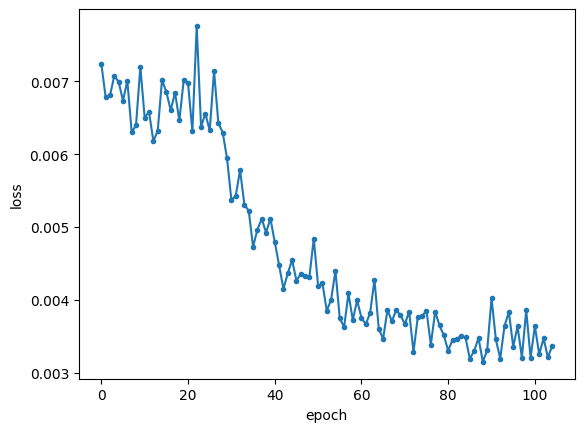

In [15]:
plot_history(hist_100)

In [16]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [17]:
# predicting output for validation data
val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 1s 901ms/step


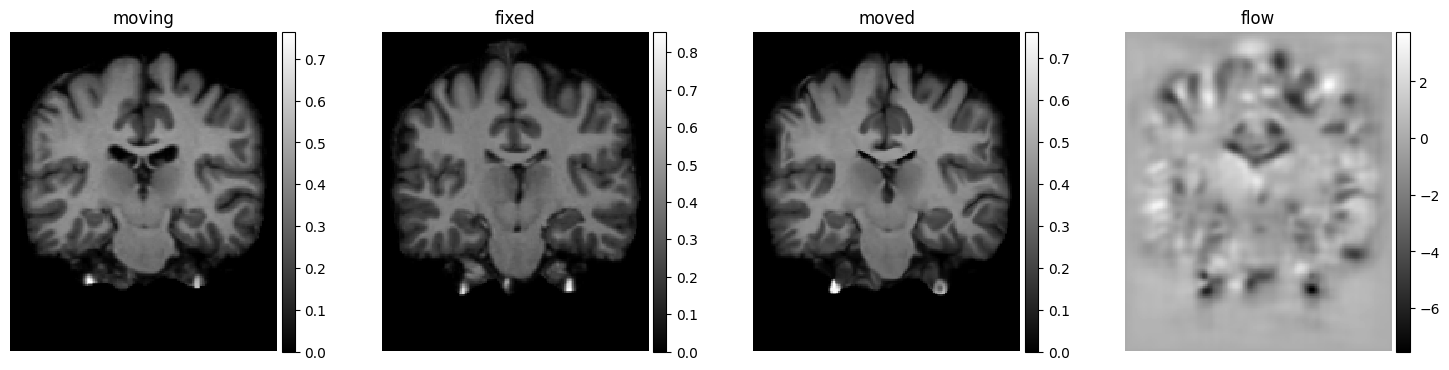

In [18]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

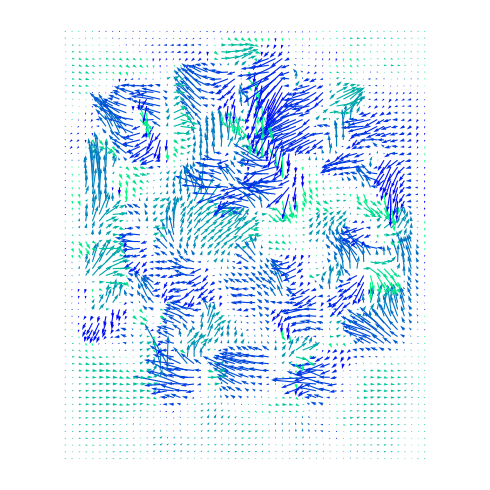

In [19]:
# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

In [ ]:
"""
 TO DO:

Train two models with different loss weights:

1. Model 1:
   - Loss weights: [1, 0.00001]
   - Train for 100 epochs

2. Model 2:
   - Loss weights: [1, 0.1]
   - Train for 100 epochs

After training, compare the results of each method to each other and analyze your findings.
"""

'\n TO DO:\n\nTrain two models with different loss weights:\n\n1. Model 1:\n   - Loss weights: [1, 0.00001]\n   - Train for 100 epochs\n\n2. Model 2:\n   - Loss weights: [1, 0.1]\n   - Train for 100 epochs\n\nAfter training, compare the results of each method to each other and analyze your findings.\n'

**Here are codes and outputs for Model 1**

In [20]:
vxm_model1 = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)
loss_weights = [1, 0.00001]
vxm_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)
hist_model1 = vxm_model1.fit_generator(train_generator, epochs=100, steps_per_epoch=5, verbose=2);

Epoch 1/100


<ipython-input-20-c7ee5c0b6a1c>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist_model1 = vxm_model1.fit_generator(train_generator, epochs=100, steps_per_epoch=5, verbose=2);


5/5 - 5s - loss: 0.0074 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 3.9488e-08 - 5s/epoch - 1s/step
Epoch 2/100
5/5 - 0s - loss: 0.0065 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 4.3698e-07 - 254ms/epoch - 51ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0072 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 2.2407e-06 - 227ms/epoch - 45ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0074 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 9.1083e-06 - 225ms/epoch - 45ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0070 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 3.2194e-05 - 243ms/epoch - 49ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0079 - vxm_dense_transformer_loss: 0.0079 - vxm_dense_flow_loss: 8.5212e-05 - 241ms/epoch - 48ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0066 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 1.0647e-04 - 230ms/epoch - 46ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_f

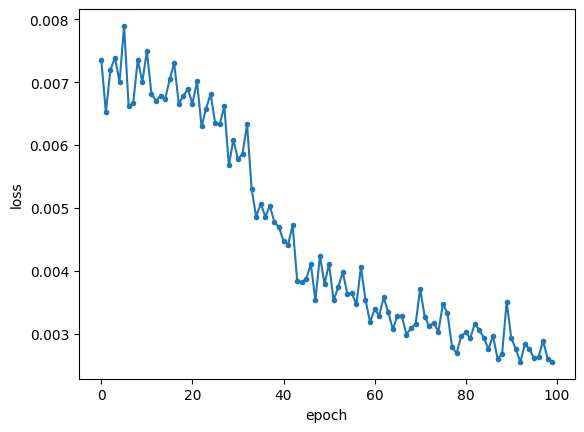

In [21]:
plot_history(hist_model1)

1/1 [==============================] - 0s 397ms/step


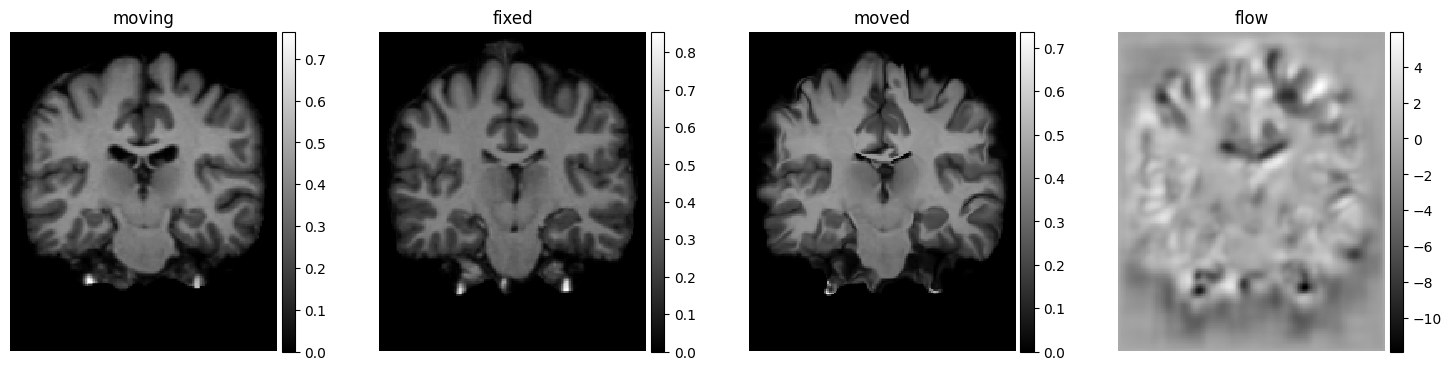

In [22]:
val_pred_model1 = vxm_model1.predict(val_input)
images = [img[0, :, :, 0] for img in val_input + val_pred_model1]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

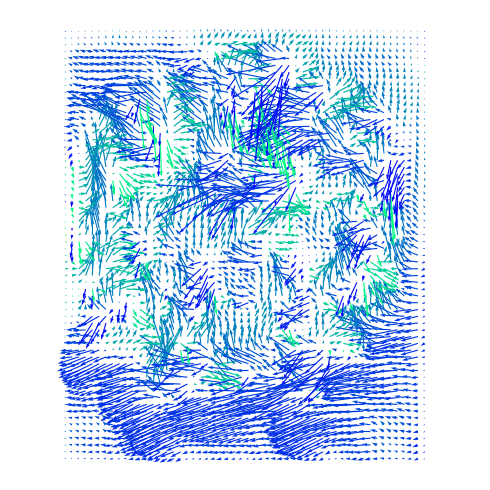

In [23]:
flow = val_pred_model1[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

In [24]:
vxm_model2 = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)
loss_weights = [1, 0.1]
vxm_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)
hist_model2 = vxm_model2.fit_generator(train_generator, epochs=100, steps_per_epoch=5, verbose=2);

Epoch 1/100


<ipython-input-24-edde7018fe31>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist_model2 = vxm_model2.fit_generator(train_generator, epochs=100, steps_per_epoch=5, verbose=2);


5/5 - 5s - loss: 0.0062 - vxm_dense_transformer_loss: 0.0062 - vxm_dense_flow_loss: 3.1265e-08 - 5s/epoch - 1s/step
Epoch 2/100
5/5 - 0s - loss: 0.0075 - vxm_dense_transformer_loss: 0.0075 - vxm_dense_flow_loss: 3.4276e-07 - 252ms/epoch - 50ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0072 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 1.5955e-06 - 231ms/epoch - 46ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0072 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 6.7275e-06 - 238ms/epoch - 48ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0064 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 2.6671e-05 - 236ms/epoch - 47ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 5.4874e-05 - 228ms/epoch - 46ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 4.3319e-05 - 228ms/epoch - 46ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0070 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_f

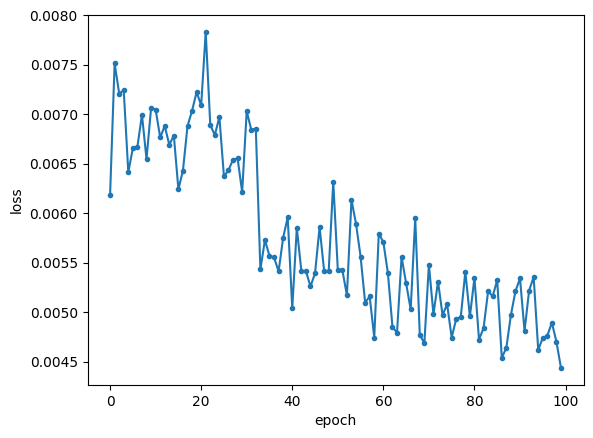

In [25]:
plot_history(hist_model2)

1/1 [==============================] - 0s 398ms/step


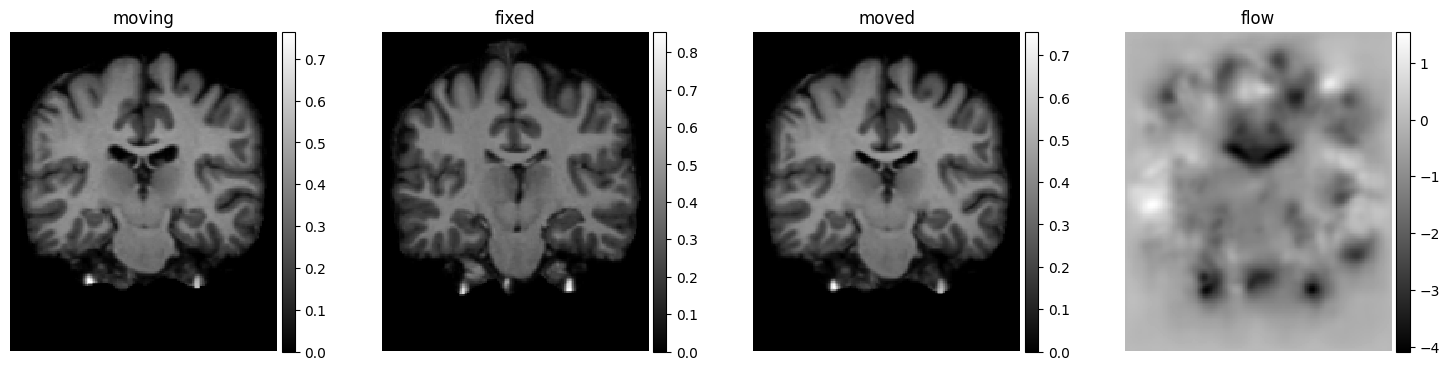

In [26]:
val_pred_model2 = vxm_model2.predict(val_input)
images = [img[0, :, :, 0] for img in val_input + val_pred_model2]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

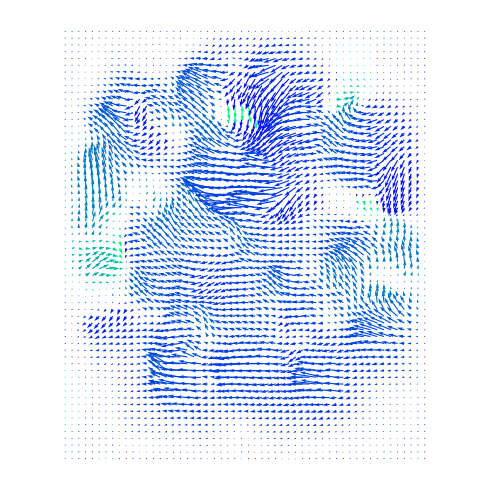

In [27]:
flow = val_pred_model2[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);